<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Evaluation-Function" data-toc-modified-id="Evaluation-Function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Evaluation Function</a></span></li><li><span><a href="#Performance-Comparison" data-toc-modified-id="Performance-Comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance Comparison</a></span><ul class="toc-item"><li><span><a href="#Undersampling" data-toc-modified-id="Undersampling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Undersampling</a></span></li><li><span><a href="#Oversampling" data-toc-modified-id="Oversampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Oversampling</a></span></li><li><span><a href="#Hybrid-Approach" data-toc-modified-id="Hybrid-Approach-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Hybrid Approach</a></span></li></ul></li></ul></div>

# Sampling Methods

The purpose of this notebook is to try different undersampling and oversampling methods to balance the proportion of positive and negative cases in the dataset.

In [1]:
# Environment Setup
from utils import *
plt.style.use('default')

Progress: [###################-] 97.3%


## Data Preparation

In [2]:
# Data
train_data = pd.read_csv('train_data_outliers.csv')
test_data = pd.read_csv('test_data_outliers.csv')
val_data = pd.read_csv('val_data_outliers.csv')
train_126 = train_data[train_data['BIRADS'].isin([1, 2, 5, 6])]

# Targets
train_y = np.where(train_data['BIRADS'].values>3, 1, 0)
test_y = np.where(test_data['BIRADS'].values>3, 1, 0)
val_y = np.where(val_data['BIRADS'].values>3, 1, 0)
train_y_126 = np.where(train_126['BIRADS'].values>3, 1, 0)

# Subset patients with BIRADS 1, 2, 6 - clear healthy and cancer cases
train_data = train_data.drop(columns=['BIRADS','PID'])
test_data = test_data.drop(columns=['BIRADS', 'PID'])
val_data = val_data.drop(columns=['BIRADS', 'PID'])
train_126 = train_126.drop(columns=['BIRADS', 'PID'])

# Get model
params = pickle.load( open( "params.pkl", "rb" ) )
model =  MLPClassifier(**params)

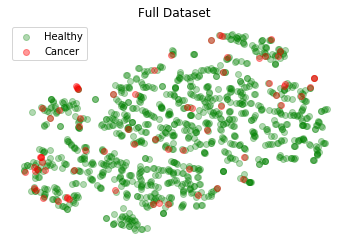

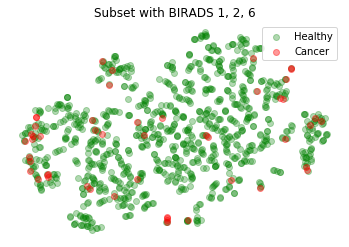

In [3]:
# BI_RADS 1,2,6 did not improve model performance
# the entire dataset is used for analysis and evaluation
plot_tsne(train_data, train_y, "Full Dataset")
plot_tsne(train_126, train_y_126, 'Subset with BIRADS 1, 2, 6')

In [4]:
print('Ratio of positives in the dataset:', 
      np.round(np.sum(train_y)/len(train_y),2))
print('Ratio of positives in the subset of BIRADS-126:', 
      np.round(np.sum(train_y_126)/len(train_y_126),2))

Ratio of positives in the dataset: 0.06
Ratio of positives in the subset of BIRADS-126: 0.05


## Evaluation Function

In [5]:
def eval_sampling(method, X_train, X_test, y_train, y_test, label, model=LogisticRegression()):
    '''Plot a set of AUC scores for a specific set.

    Inputs
    ----------
    max_comp: int
         Maximum number of components 
    X_train: dataframe or numpy array
         Training set with reduced features
    X_test: dataframe or numpy array
         Test set with reduced features
    y_train: np.array
         Training targets    
    y_test: np.array
         Test targets  
    label: str
         A title that is given to the plot
    best: bool
         Whether to pick features with best t-values
    stats: dataframe
         Output of the get_stats function
        
    Returns
    -------
    Plot of AUC values
    Maximum AUC score
    '''
    avg_base = [performance(X_train, y_train, 
                            X_test, y_test, 
                            model=model) for i in range(100)]
    aucs = [np.mean(avg_base)]
    for float_value in np.arange(0.1, 1.1, 0.1):
        sampler = method(float_value)
        avg_auc = []
        for i in range(100):
            X_res, y_res = sampler.fit_resample(X_train, y_train)
            avg_auc.append(performance(X_res, y_res, 
                                       X_test, y_test, 
                                       model=model))
        aucs.append(np.mean(avg_auc))
    plot_AUC(aucs, label)

    
def pick_method(methods, names, train_data, train_y, test_data, test_y, model):
    '''Pick the best undersampling method.

    Inputs
    ----------
    methods: list
         Sampling methods to choose from
    names: list
         Method names
    train_data: dataframe or numpy array
         Train set 
    train_y: np.array
         Training targets    
    test_data: np.array
         Test set 
    test_y: np.array
         Test targets
    model: scikit model
         Model used to evaluate methods

    Returns
    -------
    The best performing method in terms of AUC
    '''
    best_auc = 0
    best_method = None
    for i in range(len(methods)):
        X, y = methods[i].fit_resample(train_data, train_y)
        X = pd.DataFrame(X)
        auc_score = performance(X, y, test_data, 
                                test_y, detailed=False, 
                                model=model)
        print(names[i] + ' AUC score: ', 
              np.round(auc_score,2))
        if auc_score >= best_auc:
            best_auc = auc_score
            best_method = methods[i]
    return best_method

## Performance Comparison
### Undersampling

In [6]:
under_sampling_methods = [CondensedNearestNeighbour(), EditedNearestNeighbours(), 
                          RepeatedEditedNearestNeighbours(), AllKNN(), 
                          InstanceHardnessThreshold(), NearMiss(), 
                          NeighbourhoodCleaningRule(), OneSidedSelection(), 
                          RandomUnderSampler(), TomekLinks()]

under_sampling_names =   ['CondensedNearestNeighbour', 'EditedNearestNeighbours', 
                          'RepeatedEditedNearestNeighbours', 'AllKNN', 
                          'InstanceHardnessThreshold', 'NearMiss', 
                          'NeighbourhoodCleaningRule', 'OneSidedSelection', 
                          'RandomUnderSampler', 'TomekLinks']

best_undersampling = pick_method(under_sampling_methods, under_sampling_names,
                                 train_data, train_y, val_data, val_y, model=MLPClassifier(**params))

CondensedNearestNeighbour AUC score:  0.72
EditedNearestNeighbours AUC score:  0.75
RepeatedEditedNearestNeighbours AUC score:  0.75
AllKNN AUC score:  0.68
InstanceHardnessThreshold AUC score:  0.77
NearMiss AUC score:  0.58
NeighbourhoodCleaningRule AUC score:  0.65
OneSidedSelection AUC score:  0.72
RandomUnderSampler AUC score:  0.71
TomekLinks AUC score:  0.71


                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.98      0.67      0.74      0.80      0.70      0.49       350
   Positive       0.13      0.74      0.67      0.22      0.70      0.50        23

avg / total       0.92      0.68      0.73      0.76      0.70      0.49       373

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.95      0.98      0.13      0.96      0.36      0.14       350
   Positive       0.33      0.13      0.98      0.19      0.36      0.12        23

avg / total       0.91      0.93      0.18      0.92      0.36      0.14       373



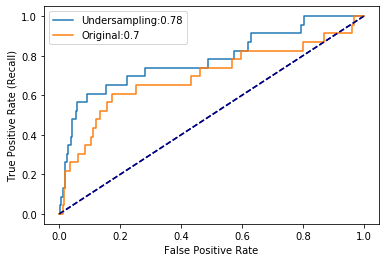

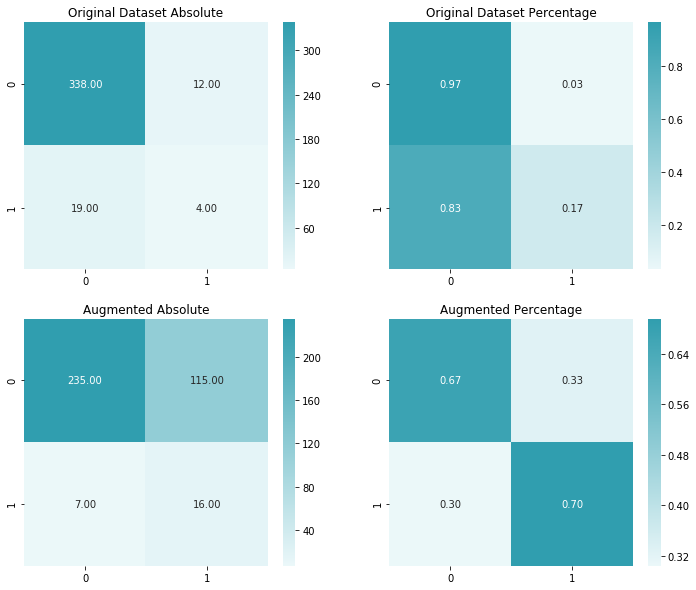

In [7]:
# Evaluation of Tomek Links
X_tomek, y_tomek = best_undersampling.fit_resample(train_data, train_y)
X_tomek = pd.DataFrame(X_tomek)

performance(X_tomek, y_tomek, 
            test_data, test_y, 
            detailed=True, 
            title="Undersampling", 
            report=True, model=MLPClassifier(**params))
performance(train_data, train_y, 
            test_data, test_y, 
            detailed=True, 
            title="Original", 
            report=True,
           model=MLPClassifier(**params))

conf_matrix_plot(train_data, train_y, 
                 X_tomek,y_tomek, 
                 test_data, test_data, 
                 test_y, test_y, 
                 MLPClassifier(**params))


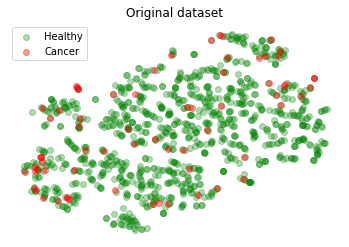

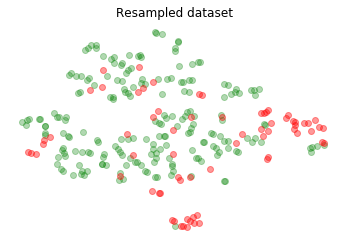

In [8]:
plot_tsne(train_data, train_y, title ='Original dataset')
plot_tsne(X_tomek, y_tomek, plot_legend=False, title ='Resampled dataset')

###  Oversampling

In [9]:
over_sampling_methods = [ADASYN(),BorderlineSMOTE(),
                         RandomOverSampler(),
                         SMOTE()]

over_sampling_names = ['ADASYN','BorderlineSMOTE',
                       'KMeansSMOTE','RandomOverSampler',
                         'SMOTE']

best_oversampling = pick_method(over_sampling_methods, 
                                over_sampling_names, 
                                train_data, train_y, 
                                val_data, val_y, 
                                model=MLPClassifier(**params))
print('Best method: ', best_oversampling)

ADASYN AUC score:  0.7
BorderlineSMOTE AUC score:  0.63
KMeansSMOTE AUC score:  0.71
RandomOverSampler AUC score:  0.74
Best method:  SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')


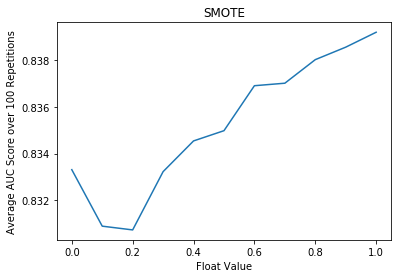

Max AUC:  0.8391977077363896


In [10]:
# Check how different values of float change the AUC score
eval_sampling(SMOTE, train_data, val_data, train_y, val_y, label='SMOTE')

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.95      0.91      0.22      0.93      0.44      0.21       350
   Positive       0.13      0.22      0.91      0.16      0.44      0.18        23

avg / total       0.90      0.86      0.26      0.88      0.44      0.21       373

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.94      0.98      0.13      0.96      0.36      0.14       350
   Positive       0.30      0.13      0.98      0.18      0.36      0.12        23

avg / total       0.91      0.93      0.18      0.91      0.36      0.14       373



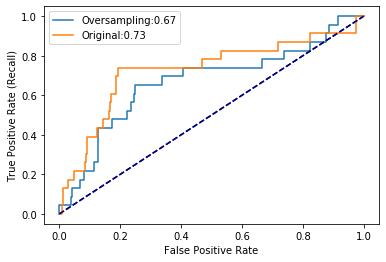

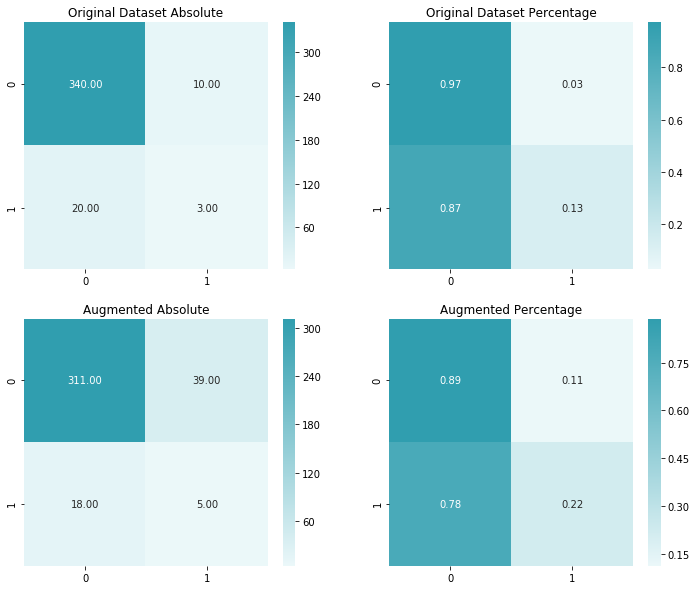

In [11]:
# Plot performance of the method with different float values
X_smote, y_smote = SMOTE(1).fit_resample(train_data, train_y)
X_smote = pd.DataFrame(X_smote)
performance(X_smote, y_smote, test_data, test_y, 
            detailed=True, title="Oversampling", 
            report=True, model=MLPClassifier(**params))
performance(train_data, train_y, test_data, test_y, 
            detailed=True, title="Original", 
            report=True, model=MLPClassifier(**params))

conf_matrix_plot(train_data, train_y, 
                 X_smote,y_smote, 
                 test_data, test_data, 
                 test_y, test_y, 
                 MLPClassifier(**params))

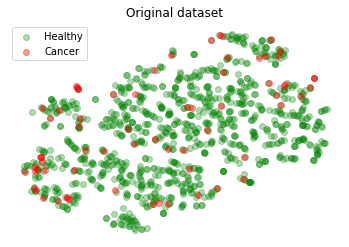

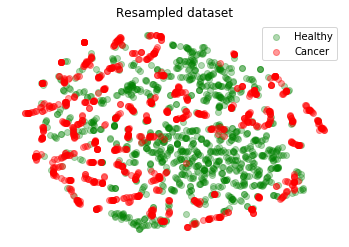

In [12]:
# Plot results
plot_tsne(train_data, train_y, 'Original dataset')
plot_tsne(X_smote, y_smote, 'Resampled dataset')

### Hybrid Approach

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.95      0.92      0.26      0.93      0.49      0.26       350
   Positive       0.18      0.26      0.92      0.21      0.49      0.22        23

avg / total       0.90      0.88      0.30      0.89      0.49      0.25       373

0.7085714285714286
                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.96      0.81      0.43      0.87      0.59      0.36       350
   Positive       0.13      0.43      0.81      0.20      0.59      0.34        23

avg / total       0.90      0.78      0.46      0.83      0.59      0.36       373

0.7170186335403727


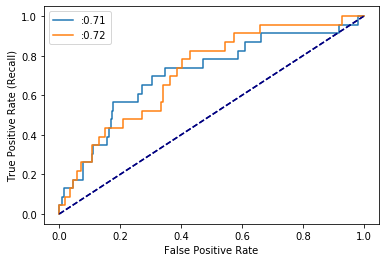

In [13]:
# Compare two hybrid methods: SMOTETomek and SMOTEENN
# SMOTETomek demonstrates better results
for method in [SMOTETomek(), SMOTEENN()]:
    X, y = method.fit_resample(train_data, train_y)
    X = pd.DataFrame(X)
    print(performance(X, y, test_data, 
                      test_y, detailed=True, 
                      report=True, 
                      model=MLPClassifier(**params)))


                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.95      0.98      0.22      0.96      0.46      0.23       350
   Positive       0.38      0.22      0.98      0.28      0.46      0.20        23

avg / total       0.92      0.93      0.26      0.92      0.46      0.23       373

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.95      0.94      0.26      0.94      0.49      0.26       350
   Positive       0.21      0.26      0.94      0.24      0.49      0.23        23

avg / total       0.91      0.90      0.30      0.90      0.49      0.26       373



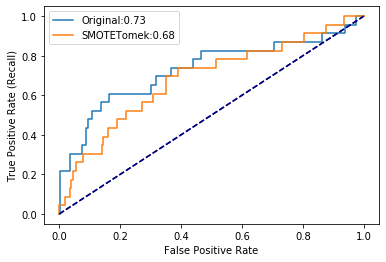

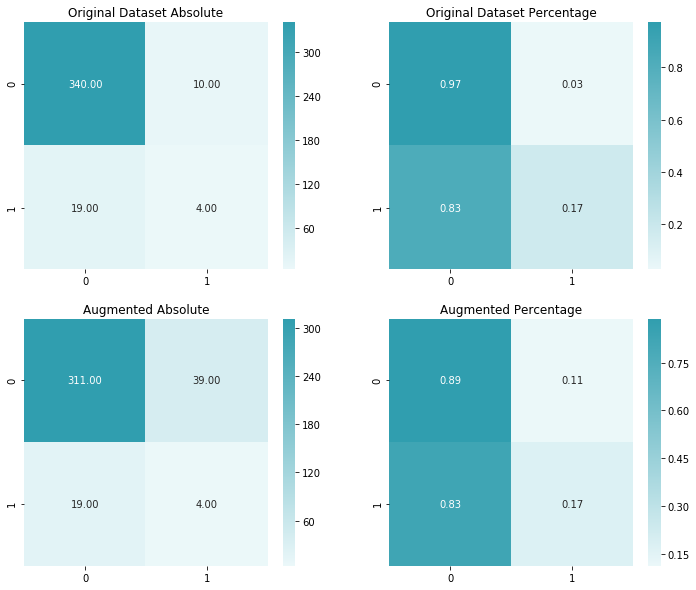

In [14]:
# Plot performance of the method with different float values
X, y = SMOTETomek(n_jobs=1, random_state=None, 
                  ratio=None, sampling_strategy='auto',
                  smote=SMOTE(1), 
                  tomek=TomekLinks()).fit_resample(train_data, train_y)
X = pd.DataFrame(X)

# Print reports and plot curves
performance(train_data, train_y, test_data, 
            test_y, detailed=True, 
            title="Original", report=True,
           model=MLPClassifier(**params))
performance(X, y, test_data, test_y, 
            detailed=True, title="SMOTETomek", 
            report=True, model=MLPClassifier(**params))

conf_matrix_plot(train_data, train_y, 
                 X,y, 
                 test_data, test_data, 
                 test_y, test_y, 
                 MLPClassifier(**params))

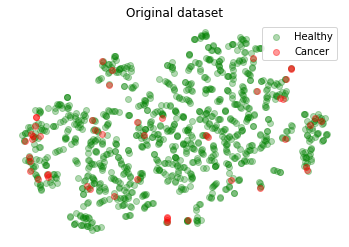

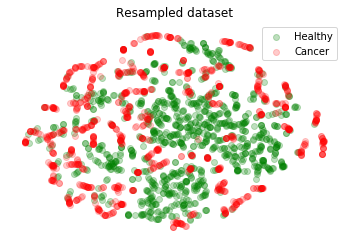

In [15]:
# Oversampling mehods have a tendency for overfitting, 
# especially for a limited number of samples.
# Plot results to check for overfitting
plot_tsne(train_126, train_y_126, title='Original dataset')
plot_tsne(X, y, alpha1=0.25, alpha2=0.2, title='Resampled dataset')